In [1]:
import os
import numpy as np
import statistics
import math

import behavior_analysis_helper_functions_new as helper
# import behavior_analysis_helper_functions as helper_old

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2nd version
<br> first portion all the way until all trials generated should work for data collected post 510 code change
<br> second half aims to plot both old and new version together

In [2]:
# sns.set_theme()
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

## Generate session log

In [3]:
# get a list of all folder names in data folder
cohort = 'cohort_2'
cohort_folder = f'/Users/rebekahzhang/Documents/shuler_lab/behavior_data/{cohort}'
data_folder = os.path.join(cohort_folder, '510_clean')
print(data_folder)
dir_list = os.listdir(data_folder)
dir_list.remove('.DS_Store')
dir_list.remove('510_all_sessions.csv')

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_2/510_clean


In [4]:
# make a table of session info with date, mouse, folder name, and file name
# TODO: can be made into a function, input dir_list, output session log, can be combined with the cell above
date_list = []
mouse_list = []
filename_list = []
for f in dir_list:
    date_list.append(f[0:10])
    mouse = f[-5:]
    mouse_list.append(mouse)
    filename_list.append(f'data_{mouse}_{f[0:19]}.txt')
session_log = pd.DataFrame({'date': date_list, 'mouse': mouse_list, 
                            'dir': dir_list, 'filename': filename_list})

In [5]:
# get the type of training from session meta data for each session
# prints the name of the session if session can't load
training_list = []
for dir_name, file_name in zip(session_log.dir, session_log.filename):
    session_meta = helper.load_session_meta(data_folder, dir_name, file_name)
    training = session_meta.training.tolist()[0]
    training_list.append(training)

session_log['training'] = training_list

In [6]:
# get a df of only regular sessions, and sort by date time
training_session_log = session_log.loc[session_log.training == 'regular'].sort_values('dir').reset_index()
training_session_log.head()

,index,date,mouse,dir,filename,training
0,6,2023-05-10,RZ012,2023-05-10_10-32-00_RZ012,data_RZ012_2023-05-10_10-32-00.txt,regular
1,33,2023-05-10,RZ013,2023-05-10_11-08-16_RZ013,data_RZ013_2023-05-10_11-08-16.txt,regular
2,1,2023-05-10,RZ014,2023-05-10_12-03-39_RZ014,data_RZ014_2023-05-10_12-03-39.txt,regular
3,7,2023-05-10,RZ015,2023-05-10_13-11-46_RZ015,data_RZ015_2023-05-10_13-11-46.txt,regular
4,9,2023-05-10,RZ016,2023-05-10_13-37-41_RZ016,data_RZ016_2023-05-10_13-37-41.txt,regular


In [7]:
# add columns of basic info to each training session
session_basics_columns = ['num_blocks', 'num_trials', 'rewards', 'time', 'proper_end']
column_names = training_session_log.columns.values.tolist() + session_basics_columns
training_session_log = training_session_log.reindex(columns=column_names)

for dir_name, file_name in zip(session_log.dir, session_log.filename):
    session = helper.load_session(data_folder, dir_name, file_name)
    session_basic = helper.get_session_basic(session)
    training_session_log.loc[training_session_log.dir == dir_name, session_basics_columns] = session_basic

In [8]:
# prints mouse names in data base, check for weird ones and delete from data base
mouse_list = session_log.mouse.unique().tolist()
mouse_list.sort()
print(mouse_list)

['RZ012', 'RZ013', 'RZ014', 'RZ015', 'RZ016', 'RZ017']


In [9]:
# session screening
# should print nothing if all sessions are reg and long enough
#### can upgrade to deleting wrong ones from data folder

# prints short sessions, to be deleted from dataset folder
short_session = training_session_log.loc[(training_session_log['training'] == 'regular') & 
                                         (training_session_log['num_trials'] < 100)] 
print(short_session.dir)

# prints dates of the same mouse with multiple sessions
for d in session_log.date.unique().tolist():
    session_of_the_day = session_log.loc[session_log['date'] == d]
    for mouse in mouse_list:
        count = len(session_of_the_day.loc[session_of_the_day['mouse'] == mouse])
        if count > 1:
            print(d, mouse)   

Series([], Name: dir, dtype: object)


In [10]:
# check for missing sessions by the number of sessions in each training day
num_mice = 6
date_list = training_session_log.date.unique().tolist()
for date in date_list:
    data = training_session_log.loc[training_session_log['date'] == date]
    if len(data) < num_mice:
        print(date)

2023-05-13
2023-05-16
2023-05-17
2023-05-18


saving session log with basic info

In [11]:
filename = f'all_sessions.csv'
path = os.path.join(data_folder, filename)
training_session_log.to_csv(path)

## Generate all trials per session

In [12]:
all_trials_column_names = ['trial_num', 'block_num', 'start_time', 'end_time', 'enl_repeats', 'blk_bg_avg', 'blk_type',
                           'bg_length', 'reward_size', 'miss_trial', 'time_waited', 'num_consumption_lick']

In [13]:
# for each session, generates all trials df and saves it in the raw data folder
# skips if all trials already exists in folder
# original version
for dir_name, file_name in zip(training_session_log.dir, training_session_log.filename):
    filename = f'{dir_name}_all_trials.csv'
    path = os.path.join(data_folder, dir_name, filename)
    # if os.path.isfile(path):
    #     continue

    session = helper.load_session(data_folder, dir_name, file_name)
    total_trial_list = helper.generate_total_trial_list(training_session_log, dir_name)
    all_trials = helper.generate_all_trials_df(all_trials_column_names, total_trial_list)
    for i in total_trial_list:
        trial = session.loc[session['session_trial_num'] == i]
        trial_data = helper.get_trial_data(trial)
        all_trials.loc[all_trials.trial_num == i, all_trials_column_names[1:]] = trial_data
        
    all_trials.to_csv(path)

In [14]:
dir_name = training_session_log.dir[1]
file_name = training_session_log.filename[1]
session = helper.load_session(data_folder, dir_name, file_name)
total_trial_list = helper.generate_total_trial_list(training_session_log, dir_name)
all_trials = helper.generate_all_trials_df(all_trials_column_names, total_trial_list)
trial = session.loc[session['session_trial_num'] == 1]

In [ ]:
trial

### all trials generated
used original to analyze data prior to 5/10, and used this new one to analyze 5/10 onwards. 
now 509 and 510 each have a session log, and each raw data folder within has all trials. 
I put 509 clean and 510 clean into full clean with all trials

In [15]:
data_folder = os.path.join(cohort_folder, 'full_clean_w_all_trials')
log_1 = os.path.join(data_folder, '509_all_sessions.csv')
training_session_log_1 = pd.read_csv(log_1, index_col=0)
log_2 = os.path.join(data_folder, '510_all_sessions.csv')
training_session_log_2 = pd.read_csv(log_2, index_col=0)
training_session_log = pd.concat([training_session_log_1, training_session_log_2])

In [16]:
training_session_log

,index,date,mouse,dir,filename,training,num_blocks,num_trials,rewards,time,proper_end
0,12,2023-04-25,RZ012,2023-04-25_11-00-06_RZ012,data_RZ012_2023-04-25_11-00-06.txt,regular,3.0,177.0,541.35,1314.41,True
1,34,2023-04-25,RZ013,2023-04-25_11-25-20_RZ013,data_RZ013_2023-04-25_11-25-20.txt,regular,2.0,107.0,367.27,832.84,False
2,75,2023-04-25,RZ014,2023-04-25_11-43-17_RZ014,data_RZ014_2023-04-25_11-43-17.txt,regular,3.0,217.0,458.45,1452.66,True
3,2,2023-04-25,RZ015,2023-04-25_12-10-41_RZ015,data_RZ015_2023-04-25_12-10-41.txt,regular,3.0,185.0,645.04,1517.78,True
4,32,2023-04-25,RZ016,2023-04-25_12-38-31_RZ016,data_RZ016_2023-04-25_12-38-31.txt,regular,3.0,199.0,528.83,1380.37,True
...,...,...,...,...,...,...,...,...,...,...,...
33,13,2023-05-18,RZ012,2023-05-18_10-16-04_RZ012,data_RZ012_2023-05-18_10-16-04.txt,regular,7.0,376.0,929.48,2796.31,True
34,15,2023-05-18,RZ013,2023-05-18_10-18-15_RZ013,data_RZ013_2023-05-18_10-18-15.txt,regular,7.0,340.0,606.73,2111.55,True
35,27,2023-05-18,RZ015,2023-05-18_10-57-02_RZ015,data_RZ015_2023-05-18_10-57-02.txt,regular,7.0,380.0,946.39,2618.22,True
36,3,2023-05-18,RZ016,2023-05-18_14-13-53_RZ016,data_RZ016_2023-05-18_14-13-53.txt,regular,7.0,404.0,548.66,2509.27,True


In [17]:
mouse_list = training_session_log.mouse.unique()
mouse_list.sort()
print(mouse_list)

['RZ012' 'RZ013' 'RZ014' 'RZ015' 'RZ016' 'RZ017']


## adding session info based on per trial performance to master log

### number of days in training

In [18]:
for mouse in mouse_list:
    total_days = sum(training_session_log.mouse == mouse)
    training_session_log.loc[training_session_log.mouse == mouse, 'days'] = list(range(total_days))

### engagement of each session
miss trials and good trials, and the proportions

In [19]:
for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    session_performance = helper.get_session_performance(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['miss_trials', 'good_trials']] = session_performance

In [20]:
training_session_log['p_miss'] = training_session_log.miss_trials/training_session_log.num_trials
training_session_log['p_good'] = training_session_log.good_trials/training_session_log.num_trials
training_session_log['p_enl'] = 1 - training_session_log.p_good - training_session_log.p_miss

<Figure size 432x288 with 0 Axes>

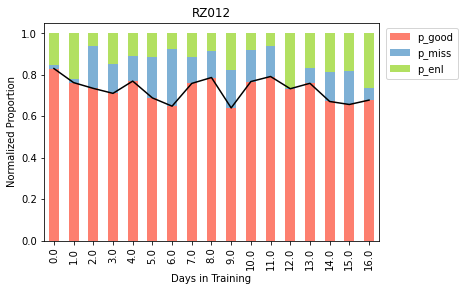

<Figure size 432x288 with 0 Axes>

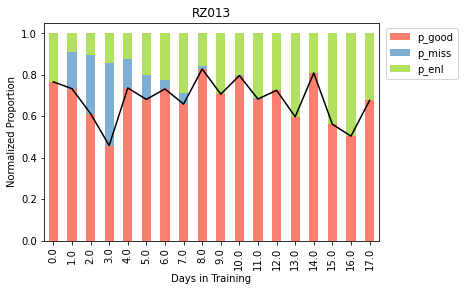

<Figure size 432x288 with 0 Axes>

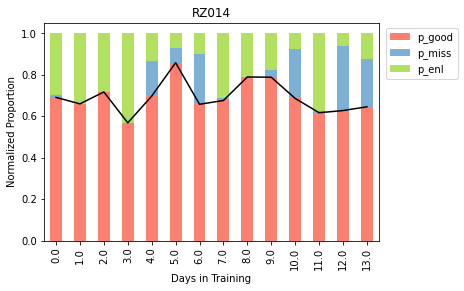

<Figure size 432x288 with 0 Axes>

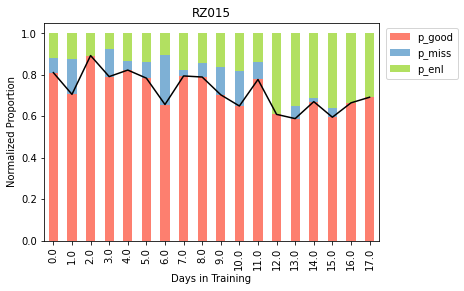

<Figure size 432x288 with 0 Axes>

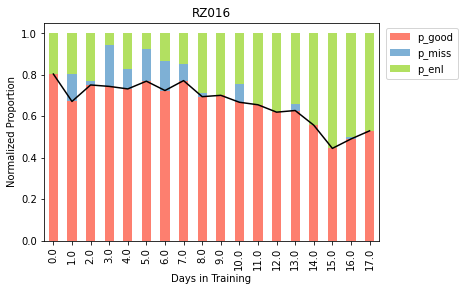

<Figure size 432x288 with 0 Axes>

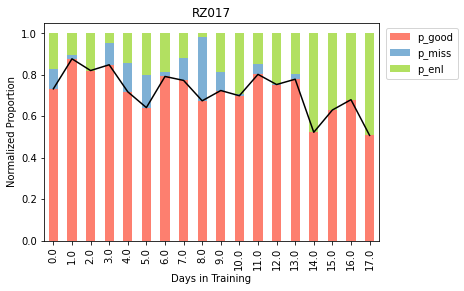

In [22]:
# plot engagement in session. each mouse has a plot
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    to_plot = session_mouse.loc[:, ['days', 'p_good','p_miss','p_enl']]
    fig = plt.figure()
    ax = to_plot.plot.bar(x='days', stacked=True, color = colors[0:3])
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Normalized Proportion')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.plot(to_plot.days, to_plot.p_good, color = 'k', linewidth=1.5)
    plt.savefig(f'engagement_{mouse}', bbox_inches='tight')

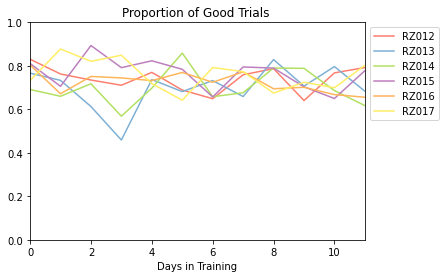

In [23]:
# plot percent good trials in session. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.p_good, color=colors[i], label=mouse)
plt.title('Proportion of Good Trials ')
plt.xlabel('Days in Training')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([0, 11])
plt.ylim([0, 1])
fig.savefig('%_good_trials.png', bbox_inches='tight')

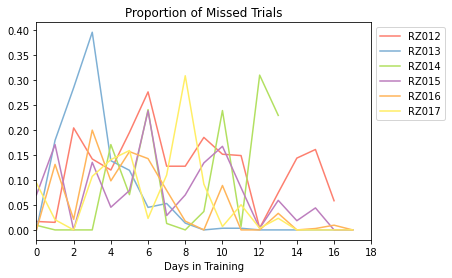

In [24]:
# plot percent missed trials in session. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.p_miss, color=colors[i], label=mouse)
plt.title('Proportion of Missed Trials')
plt.xlabel('Days in Training')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([0, 18])
# plt.ylim([0, 0.2])
fig.savefig('%_missed_trials.png', bbox_inches='tight')

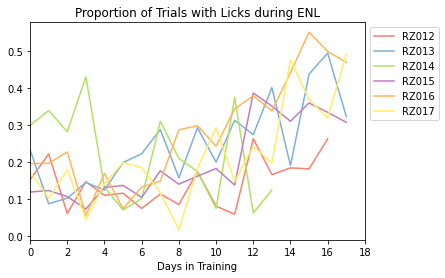

In [51]:
# plot percent missed trials in session. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.p_enl, color=colors[i], label=mouse)
plt.title('Proportion of Trials with Licks during ENL')
plt.xlabel('Days in Training')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([0, 18])
# plt.ylim([0, 0.2])
fig.savefig('%_enl_trials.png', bbox_inches='tight')

### performance of each session
reward rate, bg_repeats

In [26]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.time

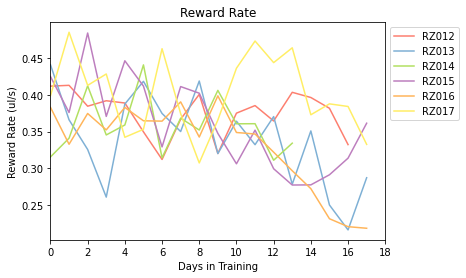

In [27]:
# plot the change in reward rate over days. each mouse is a line 
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.reward_rate, color=colors[i], label=mouse)
plt.title('Reward Rate')
plt.xlabel('Days in Training')
plt.ylabel('Reward Rate (ul/s)')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([0, 18])
# plt.ylim([0, 0.4])
fig.savefig('reward_rate.png', bbox_inches='tight')

In [28]:
for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    session_mistakes = helper.get_session_mistakes(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['num_enl_repeats_mean', 'num_enl_repeats_median', 
                              'num_enl_repeats_stdev']] = session_mistakes

In [29]:
blk_type_list = ['l', 's']
def get_session_tw_difference(all_trials):
    tw_list = []
    for blk_type in blk_type_list: 
        blk = all_trials.loc[all_trials['blk_type']==blk_type]
        tw_list.append(blk.time_waited.mean())
        tw_list.append(blk.time_waited.median())
        tw_list.append(blk.time_waited.std())
    return tw_list

In [30]:
# get time wait for long vs short trials
training_session_log['tw_l_mean'] = ''
training_session_log['tw_l_median'] = ''
training_session_log['tw_l_stdev'] = ''
training_session_log['tw_s_mean'] = ''
training_session_log['tw_s_median'] = ''
training_session_log['tw_s_stdev'] = ''

for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    tw_diff_blk = get_session_tw_difference(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['tw_l_mean', 'tw_l_median', 'tw_l_stdev',
                              'tw_s_mean', 'tw_s_median','tw_s_stdev']] = tw_diff_blk
training_session_log['tw_diff'] = training_session_log.tw_l_mean - training_session_log.tw_s_mean

In [31]:
# get time wait for long vs short trials for only good trials 
training_session_log['tw_l_mean_g'] = ''
training_session_log['tw_l_median_g'] = ''
training_session_log['tw_l_stdev_g'] = ''
training_session_log['tw_s_mean_g'] = ''
training_session_log['tw_s_median_g'] = ''
training_session_log['tw_s_stdev_g'] = ''

for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    good_trials = helper.select_good_trials(all_trials)
    tw_diff_blk = get_session_tw_difference(good_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['tw_l_mean_g', 'tw_l_median_g', 'tw_l_stdev_g',
                              'tw_s_mean_g', 'tw_s_median_g','tw_s_stdev_g']] = tw_diff_blk
training_session_log['tw_diff_g'] = training_session_log.tw_l_mean_g - training_session_log.tw_s_mean_g

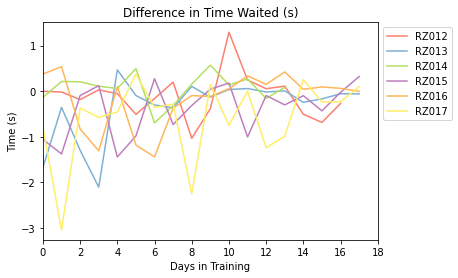

In [32]:
# plot the difference in time waited over days. each mouse is a line 
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.tw_diff, color=colors[i], label=mouse)
plt.title('Difference in Time Waited (s)')
plt.xlabel('Days in Training')
plt.ylabel('Time (s)')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([0, 18])
# plt.ylim([0, 0.4])
fig.savefig('tw_diff.png', bbox_inches='tight')

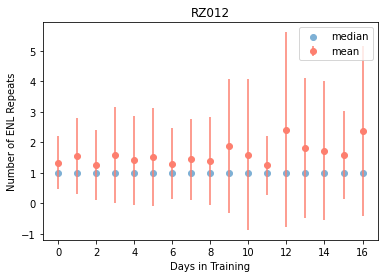

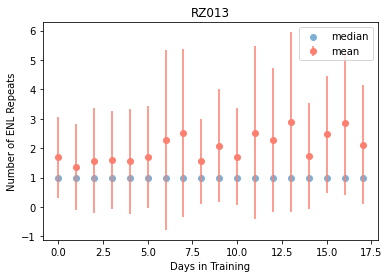

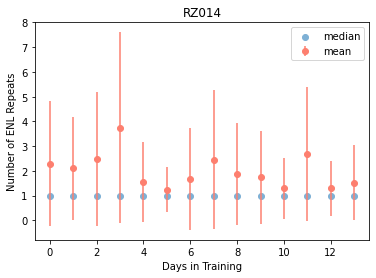

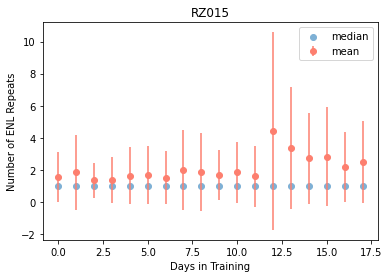

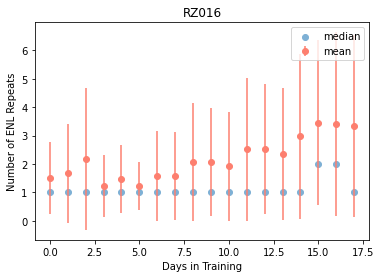

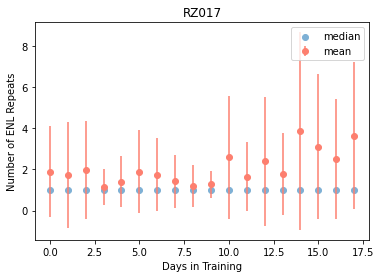

In [37]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    
    fig = plt.figure()
    plt.errorbar(session_mouse.days, session_mouse.num_enl_repeats_mean, session_mouse.num_enl_repeats_stdev, 
                 linestyle='None', marker='o', color=colors[0], label='mean')
    plt.scatter(session_mouse.days, session_mouse.num_enl_repeats_median, color=colors[1], label='median')
    plt.title(mouse)
    plt.xlabel('Days in Training')
    plt.ylabel('Number of ENL Repeats')
    plt.legend(loc='upper right')
    plt.savefig(f'enl_repeats_{mouse}', bbox_inches='tight')

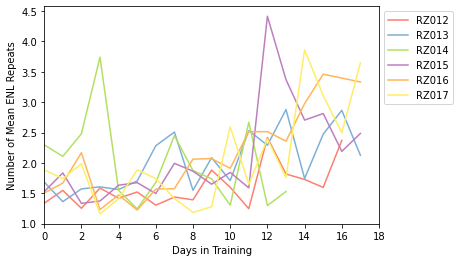

In [38]:
# plot percent mean bg repeats in session for all mice. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.num_enl_repeats_mean, color=colors[i], label=mouse)
plt.xlim([0, 18])
plt.xlabel('Days in Training')
plt.ylabel('Number of Mean ENL Repeats')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig(f'enl_repeats_mean', bbox_inches='tight')

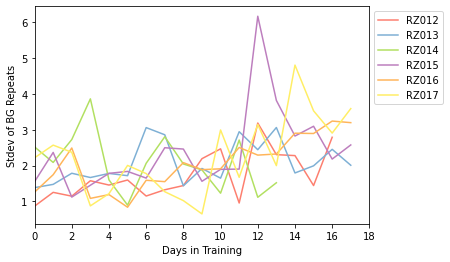

In [39]:
# plot percent stdev bg repeats in session for all mice. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.num_enl_repeats_stdev, color=colors[i], label=mouse)
plt.xlim([0, 18])
plt.xlabel('Days in Training')
plt.ylabel('Stdev of BG Repeats')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig(f'enl_repeats_stdev', bbox_inches='tight')

### wait behavior of each session

In [40]:
training_session_log['tw_mean'] = ''
training_session_log['tw_median'] = ''
training_session_log['tw_stdev'] = ''
for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    session_time_waited = helper.get_session_time_waited(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['tw_mean', 'tw_median', 'tw_stdev']] = session_time_waited

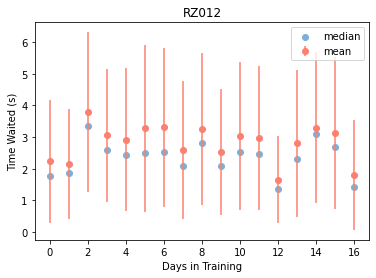

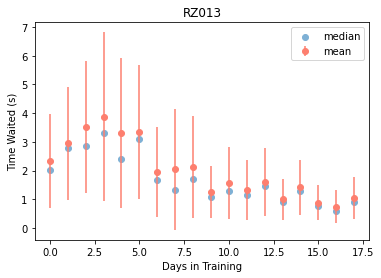

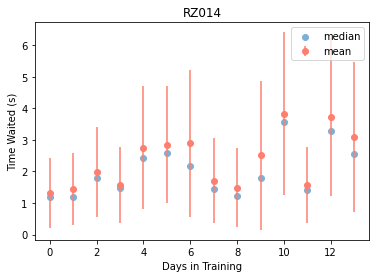

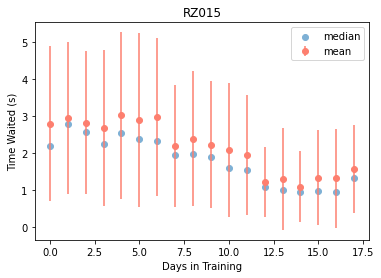

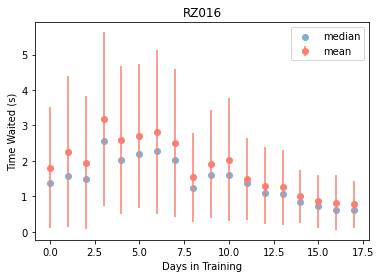

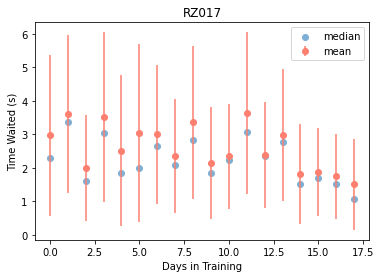

In [41]:
# plot time waited across training days for each mouse. one plot per mouse. 
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    
    fig = plt.figure()
    plt.errorbar(session_mouse.days, session_mouse.tw_mean, session_mouse.tw_stdev, 
                 linestyle='None', marker='o', color=colors[0], label='mean')
    plt.scatter(session_mouse.days, session_mouse.tw_median, color=colors[1], label='median')
    plt.title(mouse)
    plt.xlabel('Days in Training')
    plt.ylabel('Time Waited (s)')
    plt.legend(loc='upper right')
    plt.savefig(f'tw_{mouse}', bbox_inches='tight')

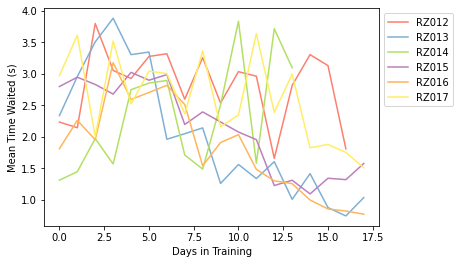

In [43]:
# plot percent mean time waited in session. each mouse is a line.
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.tw_mean, color=colors[i], label=mouse)

plt.xlabel('Days in Training')
plt.ylabel('Mean Time Waited (s)')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig(f'tw', bbox_inches='tight')

In [44]:
# time waited for only good trials 
training_session_log['tw_good_mean'] = ''
training_session_log['tw_good_median'] = ''
training_session_log['tw_good_stdev'] = ''
for dir_name in training_session_log.dir:
    all_trials = helper.load_all_trials(data_folder, dir_name)
    good_trials = helper.select_good_trials(all_trials)
    session_time_waited = helper.get_session_time_waited(good_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                             ['tw_good_mean', 'tw_good_median', 'tw_good_stdev']] = session_time_waited

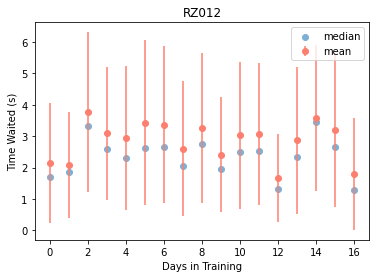

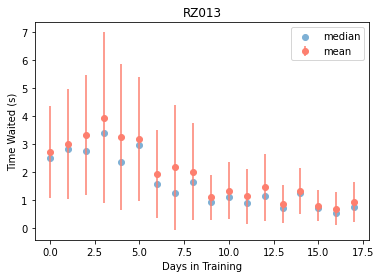

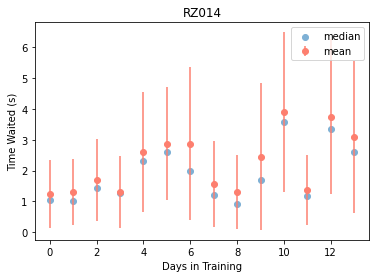

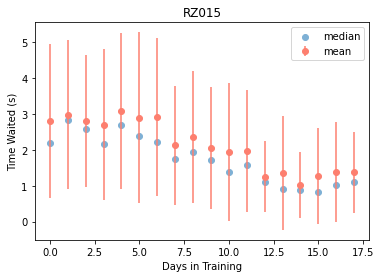

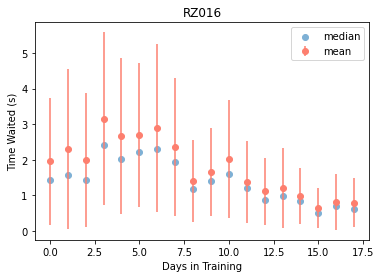

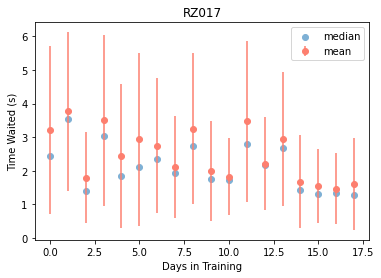

In [45]:
# plot time waited for only good trials in session. one plot per mouse
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    
    fig = plt.figure()
    plt.errorbar(session_mouse.days, session_mouse.tw_good_mean, session_mouse.tw_good_stdev, 
                 linestyle='None', marker='o', color=colors[0], label='mean')
    plt.scatter(session_mouse.days, session_mouse.tw_good_median, color=colors[1], label='median')
    plt.title(mouse)
    plt.xlabel('Days in Training')
    plt.ylabel('Time Waited (s)')
    plt.legend(loc='upper right')
    plt.savefig(f'tw_good_{mouse}', bbox_inches='tight')

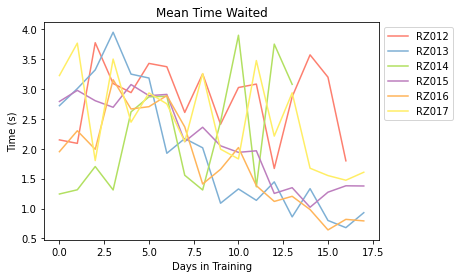

In [47]:
# plot time waited for only good trials in session. each mouse is a line
fig = plt.figure()
for i, mouse in enumerate(mouse_list):
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    plt.plot(session_mouse.days, session_mouse.tw_good_mean, color=colors[i], label=mouse)

plt.title('Mean Time Waited')
plt.xlabel('Days in Training')
plt.ylabel('Time (s)')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig(f'tw_good', bbox_inches='tight')

In [50]:
# plots all trials of time bg vs time wait of each session
# for dir_name in training_session_log.dir:
#     all_trials = helper.load_all_trials(data_folder, dir_name)
#     fig = plt.figure()
#     plt.scatter(all_trials.bg_length, all_trials.time_waited, color=colors[0])
#     days_trained = training_session_log.loc[training_session_log.dir == dir_name, 'days'].tolist()[0]
#     plt.title (f'Day {days_trained}')
#     plt.xlabel('Time in Background (s)')
#     plt.ylabel('Time Waited (s)')
#     plt.savefig(f'tw_scatter_{dir_name}', bbox_inches='tight')

In [ ]:
# plots only good trials of time bg vs time wait of each session
for dir_name in training_session_log.dir:
    all_trials = load_all_trials(data_folder, dir_name)
    good_trials = select_good_trials(all_trials)
    fig = plt.figure()
    plt.scatter(good_trials.bg_length, good_trials.time_waited, color=colors[0])
    days_trained = training_session_log.loc[training_session_log.dir == dir_name, 'days'].tolist()[0]
    plt.title (f'Day {days_trained}')
    plt.xlabel('Time in Background (s)')
    plt.ylabel('Time Waited (s)')
    plt.savefig(f'tw_good_scatter_{dir_name}', bbox_inches='tight')

In [ ]:
# plots all trials of trial number vs time wait of each session
for dir_name in training_session_log.dir:
    all_trials = load_all_trials(data_folder, dir_name)
    fig = plt.figure()
    plt.scatter(all_trials.trial_num, all_trials.time_waited, color=colors[0])
    days_trained = training_session_log.loc[training_session_log.dir == dir_name, 'days'].tolist()[0]
    plt.title (f'Day {int(days_trained)}')
    plt.xlabel('Trial Number')
    plt.ylabel('Time Waited (s)')
    plt.savefig(f'tw_by_trial_{dir_name}', bbox_inches='tight')

In [ ]:
# plots all trials of trial number vs time wait of each session
for dir_name in training_session_log.dir:
    all_trials = load_all_trials(data_folder, dir_name)
    good_trials = select_good_trials(all_trials)
    fig = plt.figure()
    plt.scatter(good_trials.trial_num, good_trials.time_waited, color=colors[0])
    days_trained = training_session_log.loc[training_session_log.dir == dir_name, 'days'].tolist()[0]
    plt.title (f'Day {int(days_trained)}')
    plt.xlabel('Trial Number')
    plt.ylabel('Time Waited (s)')
    plt.savefig(f'tw_by_trial_good_{dir_name}', bbox_inches='tight')

In [ ]:
# sns.scatterplot(x="bg_length",
#                     y="time_waited",
#                     hue="block_num",
#                     data=example_all_trials)

In [ ]:
# example_good_trials = select_good_trials(all_trials)
# sns.scatterplot(x="bg_length",
#                     y="time_waited",
#                     hue="block_num",
#                     data=example_good_trials)

### saves the master log with analyzed info

In [ ]:
# save master log with analyzed data
filename = 'all_sessions.csv'
path = os.path.join(cohort_folder, filename)
training_session_log.to_csv(path)

## block based analysis

In [ ]:
# makes a list of 0 to total block number, used to loop in the session
def generate_total_block_list(session_log, dir_name):
    current_session = session_log.loc[session_log.dir == dir_name]
    total_block_list = range(int(current_session.num_blocks.tolist()[0]) + 1)
    return total_block_list

In [ ]:
# makes an empty df with each row being a block, and each column with block info
# block number is added to the df
all_blocks_column_names = ['block_num', 'num_trials', 'blk_bg_avg', 'block_type', 'bg_repeats_avg', 
                           'bg_length_avg', 'reward_size_avg', 'num_miss_trial', 'time_waited_avg', 
                           'num_consumption_lick_avg']

def generate_all_blocks_df(column_names, total_block_list):
    all_blocks = pd.DataFrame(columns=column_names)
    all_blocks['block_num'] = total_block_list
    return all_blocks

In [ ]:
# gets block data
# takes raw data of each block as input
def get_block_data(block):
    num_trials = len(block)
    blk_bg_avg = block.blk_bg_avg.mean()
    if blk_bg_avg < 2:
        block_type = 's'
    elif blk_bg_avg > 2:
        block_type = 'l'
    else:
        print(blk_bg_avg)
    
    bg_repeats = block.bg_repeats.mean()
    bg_length = block.bg_length.mean()
    reward_size = block.reward_size.mean()
    miss_trial = block.miss_trial.sum()
    time_waited = block.time_waited.mean()
    num_cons_lick = block.num_consumption_lick.mean()
    
    return [num_trials, blk_bg_avg, block_type, bg_repeats, bg_length, 
            reward_size, miss_trial, time_waited, num_cons_lick]

In [ ]:
%%time
# for each session, generates all blocks df and saves it in the raw data folder
# skips if all_blocks.csv already exists in folder
for dir_name in training_session_log.dir:
    filename = f'{dir_name}_all_blocks.csv'
    path = os.path.join(data_folder, dir_name, filename)
    if os.path.isfile(path):
        continue
    
    all_trials = load_all_trials(data_folder, dir_name)
    total_block_list = generate_total_block_list(training_session_log, dir_name)
    all_blocks = generate_all_blocks_df(all_blocks_column_names, total_block_list)
    for i in total_block_list:
        block = all_trials.loc[all_trials['block_num'] == i]
        block_data = get_block_data(block)
        all_blocks.loc[all_blocks.block_num == i, all_blocks_column_names[1:]] = block_data
        
    all_blocks.to_csv(path)

In [ ]:
%%time
# for each session, generates all blocks df and saves it in the raw data folder
# skips if all_blocks_good_trials.csv already exists in folder
for dir_name in training_session_log.dir:
    filename = f'{dir_name}_all_blocks_good_trials.csv'
    path = os.path.join(data_folder, dir_name, filename)
    if os.path.isfile(path):
        continue
    
    all_trials = load_all_trials(data_folder, dir_name)
    good_trials = select_good_trials(all_trials) 
    total_block_list = generate_total_block_list(training_session_log, dir_name)
    all_blocks = generate_all_blocks_df(all_blocks_column_names, total_block_list)
    for i in total_block_list:
        block = good_trials.loc[good_trials['block_num'] == i]
        if len(block) == 0:
            continue
        else:
            block_data = get_block_data(block)
        all_blocks.loc[all_blocks.block_num == i, all_blocks_column_names[1:]] = block_data
        
    all_blocks.to_csv(path)

In [ ]:
# can be combined with load_all_trials, should change to read csv
def load_all_blocks(data_folder, dir_name):
    filename = f'{dir_name}_all_blocks.csv'
    path = os.path.join(data_folder, dir_name, filename)
    all_blocks_df = pd.read_csv(path, index_col=0)
    return all_blocks_df

In [ ]:
# plots all blocks of trial number vs time wait of each session
for dir_name in training_session_log.dir:
    all_blocks = load_all_blocks(data_folder, dir_name)
    good_trials = select_good_trials(all_trials)
    fig = plt.figure()
    plt.scatter(good_trials.trial_num, good_trials.time_waited, color=colors[0])
    days_trained = training_session_log.loc[training_session_log.dir == dir_name, 'days'].tolist()[0]
    plt.title (f'Day {int(days_trained)}')
    plt.xlabel('Trial Number')
    plt.ylabel('Time Waited (s)')
    plt.savefig(f'tw_by_trial_good_{dir_name}', bbox_inches='tight')

## lick analysis across sessions

In [ ]:
lick_start = session.loc[(session['key'] == 'lick') & (session['value'] == 1)]
lick_start_times = lick_start['session_time'].tolist()
lick_end = session.loc[(session['key'] == 'lick') & (session['value'] == 0)]
lick_end_times = lick_end['session_time'].tolist()
lick_times = [end - start for end, start in zip(lick_end_times, lick_start_times)]
lick_time_min = min(lick_times)
lick_time_max = max(lick_times)
lick_time_med = statistics.median(lick_times)
lick_time_avg = statistics.mean(lick_times)
lick_time_std = statistics.stdev(lick_times)

In [ ]:
for dir_name, file_name in zip(training_session_log.dir, training_session_log.filename):
    session = load_session(data_folder, dir_name, file_name)

## Furture implementation

In [ ]:
# delete short sessions. doesnt work right now because of permission issue
short_session = session_log.loc[(session_log['training'] == 'regular') & (session_log['total_trials'] < 100)] 
print(short_session)
# for dir_name in short_session.dir:
#     path = os.path.join(data_folder, dir_name)
#     os.remove(path)

In [ ]:
# print out sessions with the same mouse running more than once
mouse_list = session_log.mouse.unique().tolist()
print(mouse_list)
for d in session_log.date.unique().tolist():
    session_of_the_day = session_log.loc[session_log['date'] == d]
    for mouse in mouse_list:
        count = len(session_of_the_day.loc[session_of_the_day['mouse'] == mouse])
        if count > 1:
            print(d, mouse)   

In [ ]:
# search for background in key
for dir_name, file_name in zip(session_log.dir, session_log.filename):
    session = load_session(data_folder, dir_name, file_name)
    keys = session['key'].unique().tolist()
    if "background" not in keys:
        print(dir_name)